## REFERÊNCIAS
IDEIA ORIGINAL:
Adam Rosembrock
pyimagesearch.com - https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/




## AGENDA
Dentro do tutorial de hoje, você aprenderá como:

### Abrir uma base de imagens de raio-X (open data) de pacientes com resultado POSITIVO para COVID-19 e imagens de pacientes com resultado NEGATIVO.
### Dividir o dataset de imagens em conjunto de teste e conjunto de treino
### Aplicar a técnica de aumento de dados (Data Augmentation)
### Aplicar a técnica de transferência de inteligência entre redes neurais (Transfer Learning)
### Treinar uma Rede Neural Convolucional com o Tensorflow/Keras para detectar automaticamente o COVID-19 em imagens de raios-X
### Avaliar os resultados sob uma perspectiva educacional

## Imagens de Codiv


## Imagens Saudaveis



### bibliotecas

In [26]:
from PIL import Image
from os import listdir
from os.path import isdir
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

## carregando os dados 


In [27]:
def select_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    image = image.resize((150,150))
    # convert to array
    return np.asarray(image)

In [28]:
def load_classes(diretorio, classe, imagens, labels):
    # iterando arquivos

    for filename in listdir(diretorio):

        path = diretorio + filename

        try:
            imagens.append(select_image(path))
            labels.append(classe)
        except:
            print("Erro ao ler imagem {}".format(path))

    return imagens, labels

In [29]:
def select_data_set(diretorio):

    imagens = list()
    labels = list()

    for subdir in listdir(diretorio):
        # path
        path = diretorio + subdir + '\\'

        if not isdir(path):
            continue
        imagens, labels = load_classes(path, subdir, imagens, labels)

    return imagens, labels

In [30]:

covid_dataset = "D:/Repos/AprendendoPython/Pos_Graduacao_BigData/TCC/Projeto/dataset/"


In [43]:
imagens, labels  = select_data_set(covid_dataset)


In [44]:
imagens = np.array(imagens) / 255.0  ## convertendo de lista para array
labels = np.array(labels)  ## convertendo de lista para array

Tratando classes - Labels

In [45]:
labels[540:580]

array(['covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal'], dtype='<U6')

In [46]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [47]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [48]:
imagens[0]

array([[[0.47843137, 0.47843137, 0.47843137],
        [0.29019608, 0.29019608, 0.29019608],
        [0.29803922, 0.29803922, 0.29803922],
        ...,
        [0.29411765, 0.29411765, 0.29411765],
        [0.29019608, 0.29019608, 0.29019608],
        [0.52941176, 0.52941176, 0.52941176]],

       [[0.25490196, 0.25490196, 0.25490196],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.34509804, 0.34509804, 0.34509804]],

       [[0.2627451 , 0.2627451 , 0.2627451 ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.        , 0.        , 0.        ],
        [0.35686275, 0.35686275, 0.35686275]],

       ...,

       [[0.35686275, 0.35686275, 0.35686275],
        [0.14509804, 0.14509804, 0.14509804],
        [0.20392157, 0

Definindo hyperparametros

In [49]:
batch_size   = 32 # processar de 32 em 32
input_shape  = (150, 150, 3)  #tamanho da matriz de entrada
random_state = 42 # simular os mesmos resultados
alpha        = 1e-5
epoch        = 100

## CALLBACKS

Callback são classes que auxiliam o treinamento do modelo usando o Keras. As classes que usaremos são:

### ModelCheckpoint
###  ReduceLROnPlateau
###  EarlyStopping

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

### ModelCheckpoint
### ModelCheckpoint nos ajudará a salvar o modelo para cada época, para que possamos treinar 
nosso modelo e não nos preocuparmos com 
### possíveis problemas que possam acontecer, como travamento da máquina.

### filepath: onde será salvo o modelo
### monitor: métrica a ser monitorada
###  verbose: (1) mostra na barra de progresso (0) não
### save_best_only: Salvar somente o melhor modelo
###  mode: como vamos monitorar o 'val_acc' o valor aqui vai ser 'max'. Queremos a máxima acurácia.

In [51]:
filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### ReduceLROnPlateau Nos auxiliara a reduzir a taxa de aprendizado pelo fator (factor) caso não ocorra a mudança no loss.

### monitor: métrica a ser monitorada
###factor: fator de redução caso estejamos em um plator
### min_delta: valor mínimo da perda
### patience: só altere pelo fator após se repitir por 'patience' vezes.
### verbose: (1) mostra na barra de progresso (0) não

In [52]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)

## Array de Callbacks

In [53]:

callbacks = [checkpoint, lr_reduce]

## Particionando dataset em teste e treino

In [54]:
(trainX, testX, trainY, testY) = train_test_split(imagens, labels, test_size=0.20, stratify=labels, random_state=random_state)

## Usando a tecnica de DATA AUGMENTATION

## nesse ponto aqui , temos que intender um pouco da anatomia do pulmão , pois não podemos flipar a imagem(inveter) , 
por que o posicionamento do pulmão faz diferença pois  o pulmão direito e mais acometido por doenças virais ou bacterianas 
a traqueia da direita e mais reta do que a esquerda.

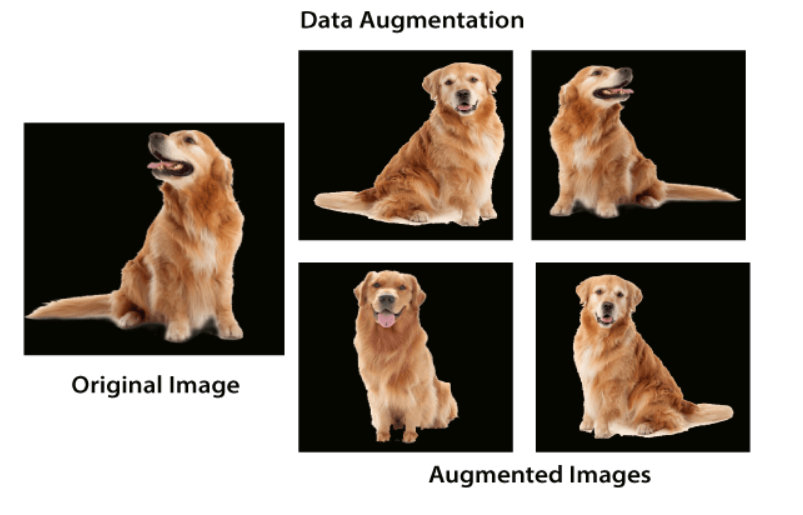

In [25]:
from IPython.display import Image
Image('D:\Repos\AprendendoPython\Pos_Graduacao_BigData\TCC\Projeto\Imagens_notebook\Data_Aumentation.png')

## No conjuto ode dados de treinamento vamos gerar novas imagens  fazendo uma rotação de 20% e um zoom de 20 %

In [55]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2)

train_datagen.fit(trainX)


## depois vamos pegar essas imagens geradas e vincular a nossa variavel target (trainY)

In [56]:

data_aug = train_datagen.flow(trainX, trainY, batch_size=batch_size)

TRANSFER LEARNING

## existe na internet um desafio chamado imagenet , com quase 12 milhoes de imagens
## e exxe desafio vai criando ao passar do tempos redes uma melhor que a outra 
## assim agente quer aproveitar essa super rede que ja foi trainada e pegar parte dela para usar no nosso problema

weights='imagenet'  vamos usar os pesos do treinamento ja feito pela  imagenet
include_top =False  não queremos o topo da rede , somente a parte das camadas covolucionais




In [57]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

80142336/80134624 [==============================] - 33s 0us/step


Total params: 20,024,384
Trainable params: 20,024,384


In [58]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## aqui vamos fazer a tecnica do ajuste fino 

As camadas inicias aprendem as carcteristicas muitos gerais  e a medida de descemos (deep) na rede 
as camadas tendem a apreder padroes mais especificos  para a tarefa quue está sendo treinada


Assim vamos manter as camadas inciais(congelar elas) e treinar novamente as camadas inferiores para que ela aprenda os nossos padrões







O ajuste fino ajuda em duas limitações

1) Nossa quantidade de dados para treinamento não e tão grande  porem podemos dar mais entendimento para a rede pre-treinada
poren não estamos utilizando o treinamento da rede toda

2) A parte que esta sendo treinada não esta sendo treinanda do zero     

In [59]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [60]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     


### GlobalAveragePooling2D  = e uma redução de resolução  vamos fazer pela media global , 
tambem podemos fazer pelo Maximo global ,pelo Minimo e pala media local

### BatchNormalization  = aumentar a estabilidade de uma rede neural , aplica uma normalização na saida do neuronio

### Flatten = faz o achatamento da matriz para um array 

### Uma camanda densa de 128 neuronios (vamos testar com 128 e 256 neuronios)

### Dropout vamos desligar 60 % dos neuronios para evitar que o modelo decore as regras de associacao (testar com 50 % tambem) 
assim vamos generalizar mais a rede (diminuir o overfit)


### ultima camada (camada densa de 2 saidas ( 0 ou 1 (com covid ou normal )))

### 


In [61]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))

In [62]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

## treinamento da rede 


In [ ]:
history = model.fit_generator(
                              data_aug,
                              steps_per_epoch=len(trainX)// batch_size, # parte inteira da divisão
                              validation_data=(testX, testY),
                              validation_steps=len(testX) // batch_size,# parte inteira da divisão
                              callbacks=callbacks,
                              epochs=epoch)

Analisando os resultados

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Gerando matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testY,axis = 1)

In [ ]:
cm = confusion_matrix(y_true, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

Também estamos obtendo 100% de sensibilidade e 92% de especificidade, o que implica que:

Sensibilidade, capacidade indentificar caso positivo de COVID-19 com o modelo é de 100%.
Especificidade, capacidade indentificar caso Não-Positivo de COVID-19 com o modelo é de 92,31%.
Como mostra nosso gráfico de histórico de treinamento, nossa rede não está adaptando demais, apesar de ter dados de treinamento limitado